This walkthrough will demonstrate some potential approaches to using CAP bulk data via the publically whitelisted Illinois bulk dataset in XML format (1.4 GB compressed) https://capapi.org/bulk-access/. All packages come standard with Anaconda, with the exception of the (optional) PyQuery parser.

In [4]:
import os
import xml.etree.cElementTree as ET

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
se.set_style('white')
se.set_context('poster')


from ipywidgets import FloatProgress
from IPython.display import display

%matplotlib inline

First, let's get a list of relative filepaths to all of the XML documents in the Illinois dataset. Note that this  assumes that the uncompressed folder containing the files is placed in the same directory as this script – modify as needed.

In [2]:
files = []
for directory in os.walk("./Illinois-20180619"):
    if directory[2]:
        for file in [f for f in directory[2] if f[-4:] == ".xml"]:
            files.append(os.path.join(directory[0], file))
            
print ("{} XML Case Files Found".format(len(files)))

183149 XML Case Files Found


That's a lot of files - the uncompressed Illinois dataset is more than 7 GB. If you'd like to decrease runtime, you can just sample 50,000 files for now. This function parses some basic information from the XML docs. Note that further information can be parsed from the XML files – this is just a sampling.

A note on parsers: the first (default) parser below is a very fast implementation in cElementTree, which some users may find difficult to modify. The second parser is a comparable implementation in PyQuery (credit to Jack Cushman https://github.com/jcushman), which is considerably easier to modify. cElementTree comes with most installations of Python, whereas PyQuery must be installed.

In [3]:
# ~10 minutes to parse all 183,149 files on a laptop    
def ET_parse_xml(filename):
    feat_dict = {}
    header = True
    for event, elem in ET.iterparse(filename):
        strp_tag = elem.tag.split("}")[1]
        if header:
            if strp_tag == "court":
                feat_dict["court"] = elem.text
                feat_dict["jurisdiction"] = elem.attrib["jurisdiction"]
            elif strp_tag == "name":
                feat_dict["name"] = elem.text.replace(u'\xad', '')
            elif strp_tag == "citation":
                feat_dict["citation"] = elem.text
            elif strp_tag == "decisiondate":
                feat_dict["date"] = elem.text
                header=False
            elem.clear()
        else:
            if strp_tag == "casebody":
                opinions = []
                for child in elem.getchildren():
                    if child.tag.split("}")[1] == "opinion":
                        op = {}
                        text = []
                        op["type"] = child.attrib["type"]
                        op["author"] = ""
                        for opinion_element in child.getchildren():
                            if opinion_element.tag.split("}")[1] == 'author':
                                op["author"] = opinion_element.text.replace(u'\xad', '')
                            else:
                                text.append(opinion_element.text.replace(u'\xad', ''))
                        op["text"] = " ".join(text)
                        opinions.append(op)
                feat_dict["opinions"] = opinions
                return feat_dict

In [4]:
# ~13 minutes to parse all 183,149 files on a laptop
# SKIP if you want to use the default parser
from pyquery import PyQuery

nsmap = {
    'case': 'http://nrs.harvard.edu/urn-3:HLS.Libr.US_Case_Law.Schema.Case:v1',
    'casebody': 'http://nrs.harvard.edu/urn-3:HLS.Libr.US_Case_Law.Schema.Case_Body:v1',
}

def pyq_parse_xml(filename):
    parsed = PyQuery(filename=filename, parser='xml', namespaces=nsmap)
    court = parsed('case|court')
    return {
        'court': court.text(),
        'jurisdiction': court.attr('jurisdiction'),
        'name': parsed('case|name').text().replace(u'\xad', ''),
        'citation': parsed('case|citation').eq(0).text(),
        'date': parsed('case|decisiondate').text(),
        'opinions': [
            {
                'type': opinion.attr('type'),
                'author': opinion('author').text().replace(u'\xad', ''),
                'text': opinion.text(),
            }
            for opinion in parsed('casebody|opinion').items()
        ]
    }

In [5]:
#Add progress bar
bar = FloatProgress(min=0, max=len(files))
display(bar)

#For each file, parse with parse_xml() and add to list of parsed files
parsed_files = []
for file in files:
    doc = ET_parse_xml(file) #If you would like to use the PyQuery parser, change the function name here!
    parsed_files.append(doc)
    bar.value += 1

#You may want to dump the files to a JSON document here, or pickle the dataframe after generating it

FloatProgress(value=0.0, max=183149.0)

Let's load these parsed files into pandas for ease of manipulation...

In [6]:
raw_df = pd.DataFrame(parsed_files)
#Parse dates
raw_df["date"] = pd.to_datetime(raw_df["date"])
#Strip out some sparse early data
df = raw_df[raw_df["date"] >= '1850-01-01']
df.head()

,citation,court,date,jurisdiction,name,opinions
0,4 Colo. L. Rep. 741,Illinois Supreme Court,1884-05-19,Illinois,WEILAND et al. v. KOBICK,"[{'type': 'majority', 'author': 'Sheldon, C. J..."
1,3 Colo. L. Rep. 119,Illinois Circuit Court,1882-01-01,Illinois,HAMLIN v. DAVIS et al.,"[{'type': 'majority', 'author': 'Tuley, J.', '..."
2,2 Colo. L. Rep. 116,Illinois Supreme Court,1881-06-20,Illinois,PEOPLE v. GOSS AND PHILLIPS MANUFACTURING COMPANY,"[{'type': 'majority', 'author': 'Dickey, J.,',..."
3,61 Ill. App. 2d 414,Illinois Appellate Court,1965-07-30,Illinois,"Joseph M. Baron and Jane M. Baron, Plaintiffs-...","[{'type': 'majority', 'author': 'ME. JUSTICE K..."
4,61 Ill. App. 2d 325,Illinois Appellate Court,1965-06-15,Illinois,"George J. Franks, Plaintiff-Appellant, v. Paul...","[{'type': 'majority', 'author': 'JUSTICE LYONS..."


So we've got a host of useful information here, including jurisdiction, court, case name, citation, date, and, of course, the case text broken down by opinion. Let's ask a question: on a case insensitive basis, how does n-gram frequency reflect the emergence of new technologies?

In [7]:
#Takes a dataframe of cases and an n-gram and returns a list of (year, n-gram count) tuples
def get_ngram_count(cases, ngram):
    
    #Build a dictionary of all years present in the dataframe
    result = {year:0 for year in cases["date"].apply(lambda x: x.year).unique()}
    #Across all cases...
    for _, case in cases.iterrows():
        mentions = 0
        for opinion in case['opinions']:
            #...count all cases containing n-gram using dictionary entries
            if (ngram in opinion['text'].lower()):
                result[int(case['date'].year)] += 1
                break
    #Return a sorted list of the tuples
    return sorted(list(result.items()), key=lambda x:x[0])

#Visualize an ngram using matplotlib, passing in an axis
def visualize_ngram(title, ax, ngram_data):
    #Get counts of each year across case decision dates (we use to this to calculate proportion of cases with n-gram)
    year_counts = df["date"].apply(lambda x:x.year).value_counts().sort_index().values
    ax.set_xlim(1850,2020)
    ax.set_title("'{}' occurs in {} cases".format(title, sum(x[1] for x in ngram_data)))
    ax.set_ylabel("Proportion of cases with ngram")
    ax.set_xlabel("Year Decided")
    #Years on the x-axis, n-gram counts on the y axis
    ax.plot([x[0] for x in ngram_data], [x[1] for x in ngram_data]/year_counts)

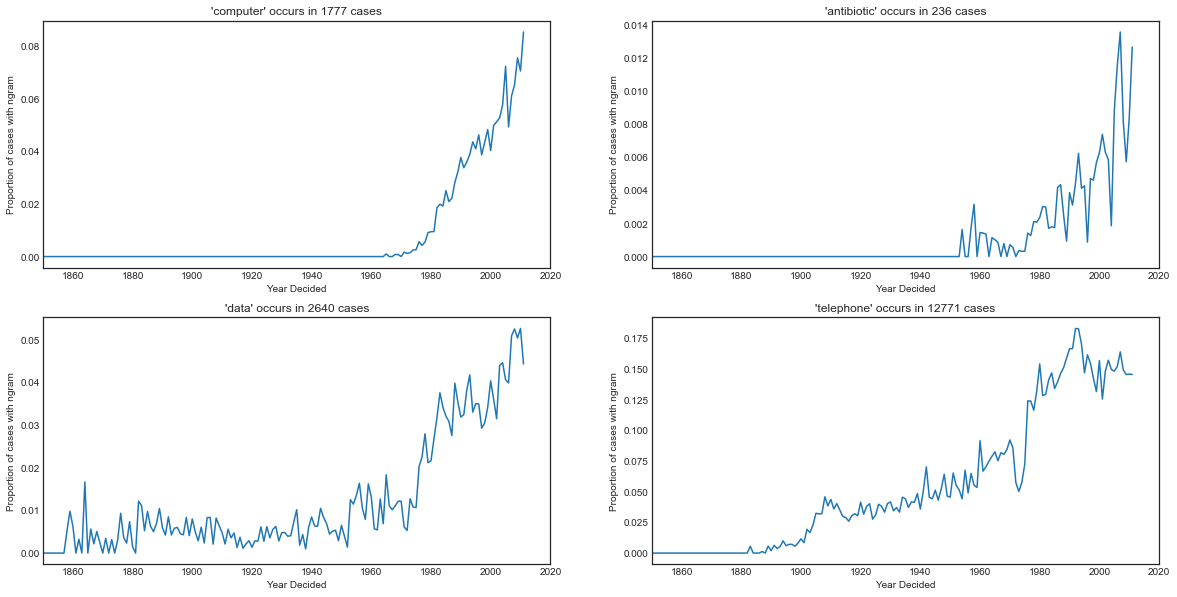

In [8]:
#NOTE: This code takes quite a while to run
#Generate subplots
fig, axes = plt.subplots(2, 2, figsize=(20,10))

#generate visualizations for n-grams, passing a matplotlib axis for each
visualize_ngram("computer", axes[0,0], get_ngram_count(df, "computer"))
visualize_ngram("antibiotic", axes[0,1], get_ngram_count(df, "antibiotic"))
visualize_ngram("data", axes[1,0], get_ngram_count(df, " data "))
visualize_ngram("telephone", axes[1,1], get_ngram_count(df, "telephone"))

Next, let's look at the average length of cases varies between Illinois courts.

In [8]:
#Let's look at how many cases fall in each court
df['court'].value_counts(normalize=False)

Illinois Appellate Court                                              123911
Illinois Supreme Court                                                 47804
Illinois Court of Claims                                                9847
Illinois Circuit Court                                                   201
United States District Court for the Northern District of Illinois         3
Illinois Appellate Court`                                                  1
i                                                                          1
Illinois Court of Claims \n                                                1
Illinois Appellate Court Reports                                           1
Illinois Appellate Court.                                                  1
Name: court, dtype: int64

In [9]:
#Let's trim to just the 4 non-broken court types
df = df[df['court'].isin(df['court'].value_counts()[:4].index.tolist())]

In [10]:
#Let's get the average length of a case in words for each court
court_lengths = []

#Build a list of tuples indicating average lengths for each court
for court in df["court"].unique():
    num = df[df["court"] == court].shape[0]
    lens = sum(df[df["court"] == court]["opinions"].apply(lambda x: sum([len(op["text"].split(" ")) for op in x])))
    court_lengths.append((court, lens/num))

#Sort by average length
court_lengths = sorted(court_lengths, key=lambda x: x[1])
court_lengths

[('Illinois Court of Claims', 610.1456281100843),
 ('Illinois Appellate Court', 1921.146088724972),
 ('Illinois Supreme Court', 2078.9101121245085),
 ('Illinois Circuit Court', 2423.6417910447763)]

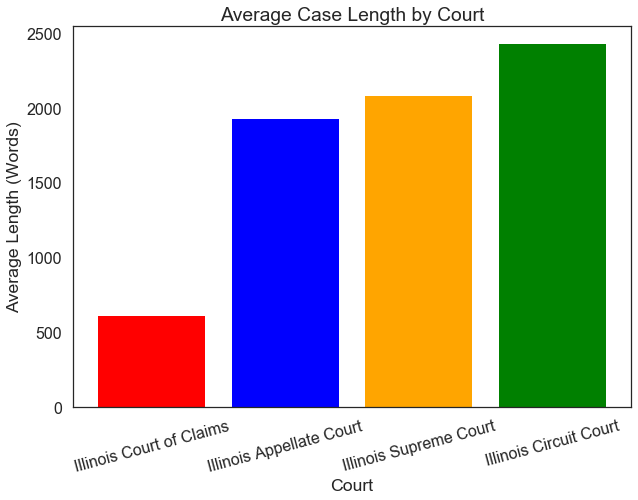

In [11]:
#Build a dictionary of court:color mappings for consistency across graphs
court_color_dict = {
    'Illinois Court of Claims': 'red',
    'Illinois Appellate Court': 'blue',
    'Illinois Supreme Court' : 'orange',
    'Illinois Circuit Court': 'green'
}

#Display bar plot of lengths
plt.figure(figsize=(10,7))
for i, court in enumerate(court_lengths):
    plt.bar(i, court[1], color=court_color_dict[court[0]])

plt.title("Average Case Length by Court")
plt.xlabel("Court")
plt.ylabel("Average Length (Words)")
plt.xticks(list(range(0,len(court_lengths))), [x[0] for x in court_lengths])
locations, labels = plt.xticks()
plt.setp(labels, rotation=15)

plt.show()

In [12]:
#Let's get the average length of a case in words for each court over time
court_lengths_chron = {}

#Get a list of dates in 2 year intervals from 1850-2012
drange = pd.date_range('1850-01-01', '2012-01-01', freq='2Y')

#For each court...
for court in df["court"].unique():
    #Add key for court in dictionary, and associate with a new list.
    #This list will hold average lengths for each span in our date range
    court_lengths_chron[court] = []
    for span in drange:
        end_span = span.replace(year = span.year + 2)
        #Filter to span
        df_temp = df[(df["court"] == court) & (df["date"] >= span) & (df["date"] < end_span)]
        num = df_temp.shape[0]
        #Get total words for court cases in span
        lens = sum(df_temp["opinions"].apply(lambda x: sum([len(op["text"].split(" ")) for op in x])))
        #Add average or None to list
        if num > 0:
            court_lengths_chron[court].append(lens/num)
        else:
            court_lengths_chron[court].append(None)

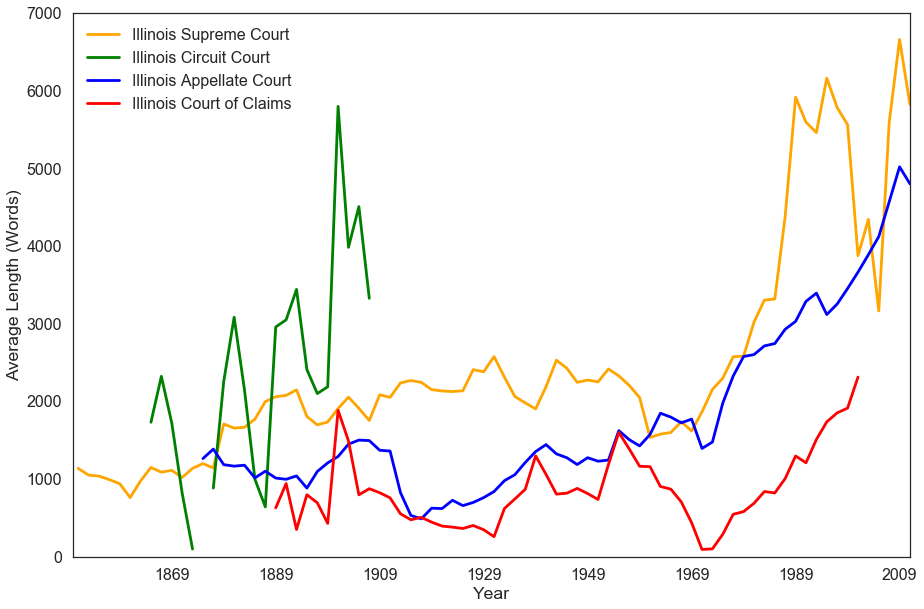

In [13]:
#Graph average lengths over time for each court
plt.figure(figsize=(15,10))
for court in court_lengths_chron.keys():
    plt.plot(drange, court_lengths_chron[court], label=court, color=court_color_dict[court])
    
plt.legend()
plt.xlim('1850-01-01','2011-01-01')
plt.xlabel("Year")
plt.ylabel("Average Length (Words)")
plt.ylim(0,7000)
plt.show()

There are times where we would prefer to analyze case data primarily on the opinion level rather than the case level. Let's reshape our dataframe to contain a row for each individual opinion.

In [14]:
array_opinions = []

#Loop thorugh case dataframe and flatten opinions
for _, row in df.iterrows():
    for opinion in row["opinions"]:
        temp = {}
        keys = list(row.keys())
        keys.remove('opinions')
        for key in keys:         
            temp[key] = row[key]
        keys = list(opinion.keys())
        for key in keys:         
            temp[key] = opinion[key]
        array_opinions.append(temp)

df_opinions = pd.DataFrame(array_opinions)
df_opinions.head(3)

,author,citation,court,date,jurisdiction,name,text,type
0,"Sheldon, C. J.",4 Colo. L. Rep. 741,Illinois Supreme Court,1884-05-19,Illinois,WEILAND et al. v. KOBICK,This was an action of ejectment for the recove...,majority
1,"Tuley, J.",3 Colo. L. Rep. 119,Illinois Circuit Court,1882-01-01,Illinois,HAMLIN v. DAVIS et al.,This is a bill filed by complainant against th...,majority
2,"Dickey, J.,",2 Colo. L. Rep. 116,Illinois Supreme Court,1881-06-20,Illinois,PEOPLE v. GOSS AND PHILLIPS MANUFACTURING COMPANY,"in delivering the opinion of the Court, said: ...",majority


For example, let's say we want to generate a list of the most prolific judges in our dataset...

In [15]:
most_prolific = df_opinions["author"].value_counts()
#This gets around bugs related to .lower() in some versions of pandas
most_prolific = most_prolific[~most_prolific.index.str.contains('uriam')]
most_prolific = most_prolific[~most_prolific.index.str.contains('CURIAM')]
most_prolific = most_prolific.drop("")
most_prolific.head()

Mr. Justice Cartwright    1619
Mr. Justice Carter        1377
Mr. Justice Craig         1346
Mr. Justice Dunn          1285
Mr. Justice Stone         1200
Name: author, dtype: int64

Let's generate a dictionary of all Illinois judges who have written opinions so that we can analyze patterns in written output over time. Each entry in the dictionary will be a subdictionary of years, with entries indicating how many opinions the judge authored in the corresponding year.

In [16]:
authors = {}
for _, opinion in df_opinions.iterrows():
    if opinion["author"] and "curiam" not in opinion["author"]:
        author = opinion["author"]
        year = opinion["date"].year
        if "curiam" in author.lower():
            author = 'Per Curiam.'
        #add to dictionary of authors with subdictionary of years for each author
        if author in authors:
            if year in authors[author]:
                authors[author][year] += 1
            else:
                authors[author][year] = 1
        else:
            authors[author] = {}
            authors[author][year] = 1

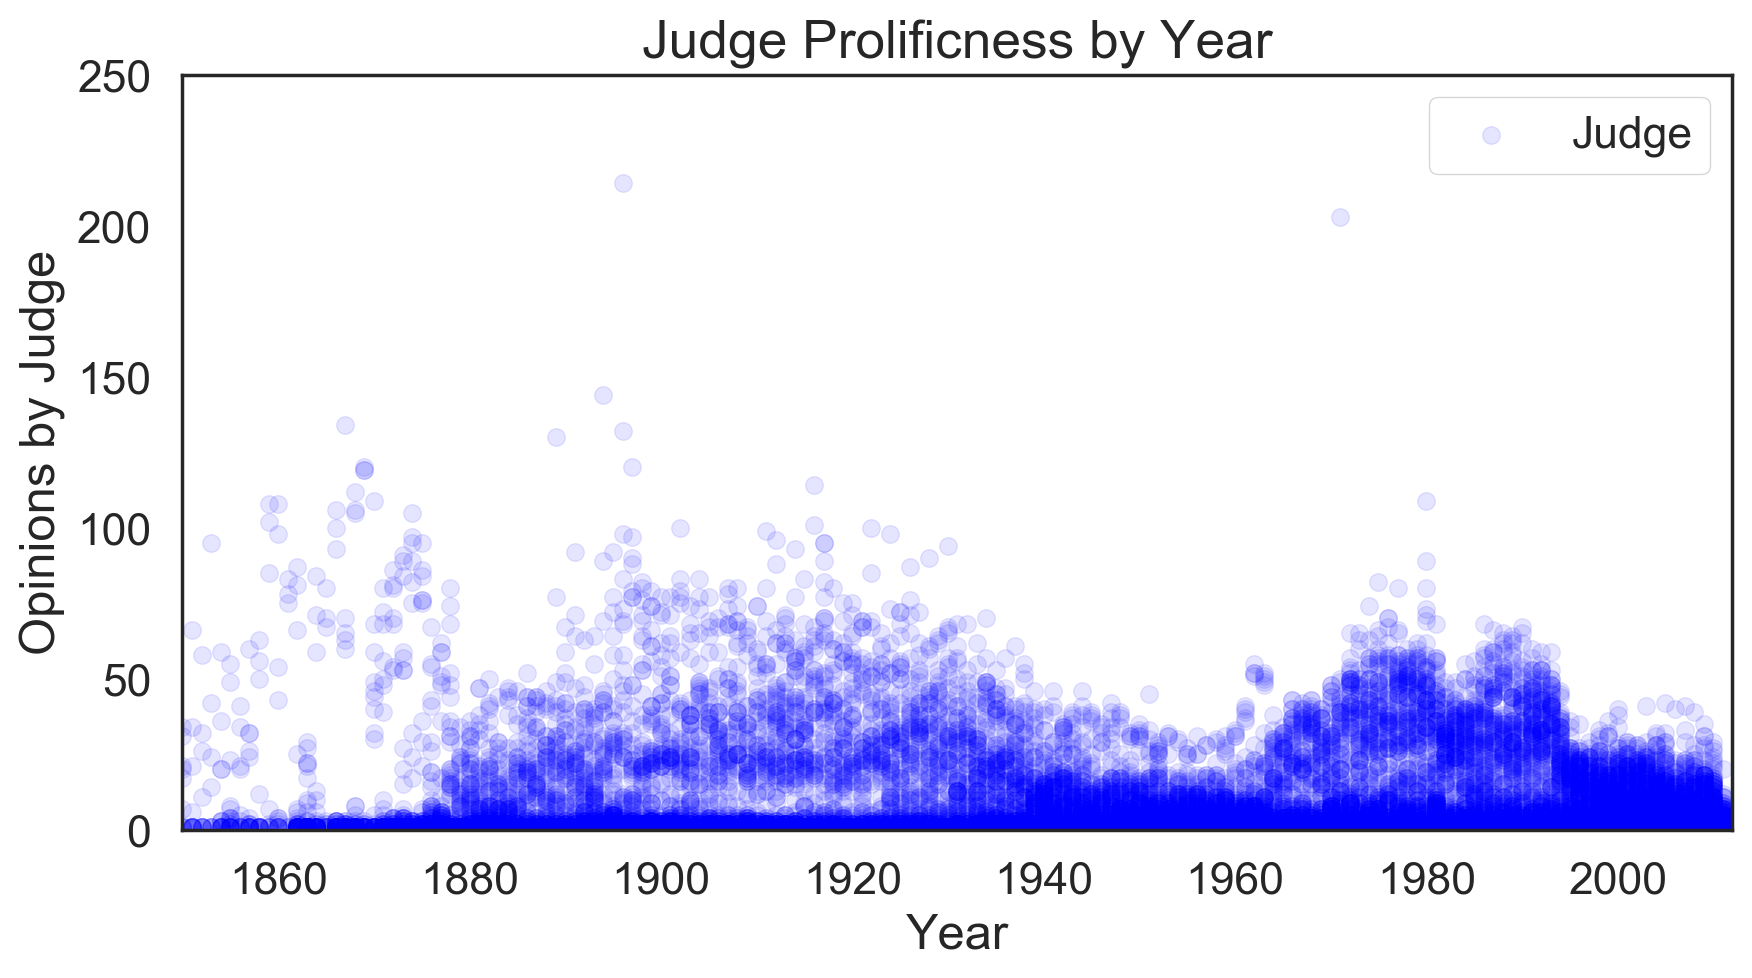

In [45]:
plt.figure(figsize=(10,5), dpi=200)
plt.ylim(0, 250)
plt.xlim(1850, 2012)

#build lists of year/opinion count coordinates across all justices
x, y = [], []
for justice in most_prolific.index.tolist():
    temp_x,temp_y = zip(*authors[justice].items())
    x.extend(temp_x)
    y.extend(temp_y)

plt.title("Judge Prolificness by Year")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.scatter(x,y, color='blue', alpha=0.1, s=40, label='Judge')
#c_x,c_y = zip(*authors["Mr. Justice Cartwright"].items())
#plt.scatter(c_x,c_y, alpha=0.5, s=40, label="Cartwright", color="red")

plt.legend(frameon=True)
plt.savefig("prolificness1.png")
plt.show()

Interesting – it seems that today's judges tend to write fewer opinions per year than their predecessors – look at what the judges of the late 19th and early 20th century were doing! Next, let's look at the 10 most prolific judges in our (uncleaned) dataset.

NameError: name 'most_prolific' is not defined

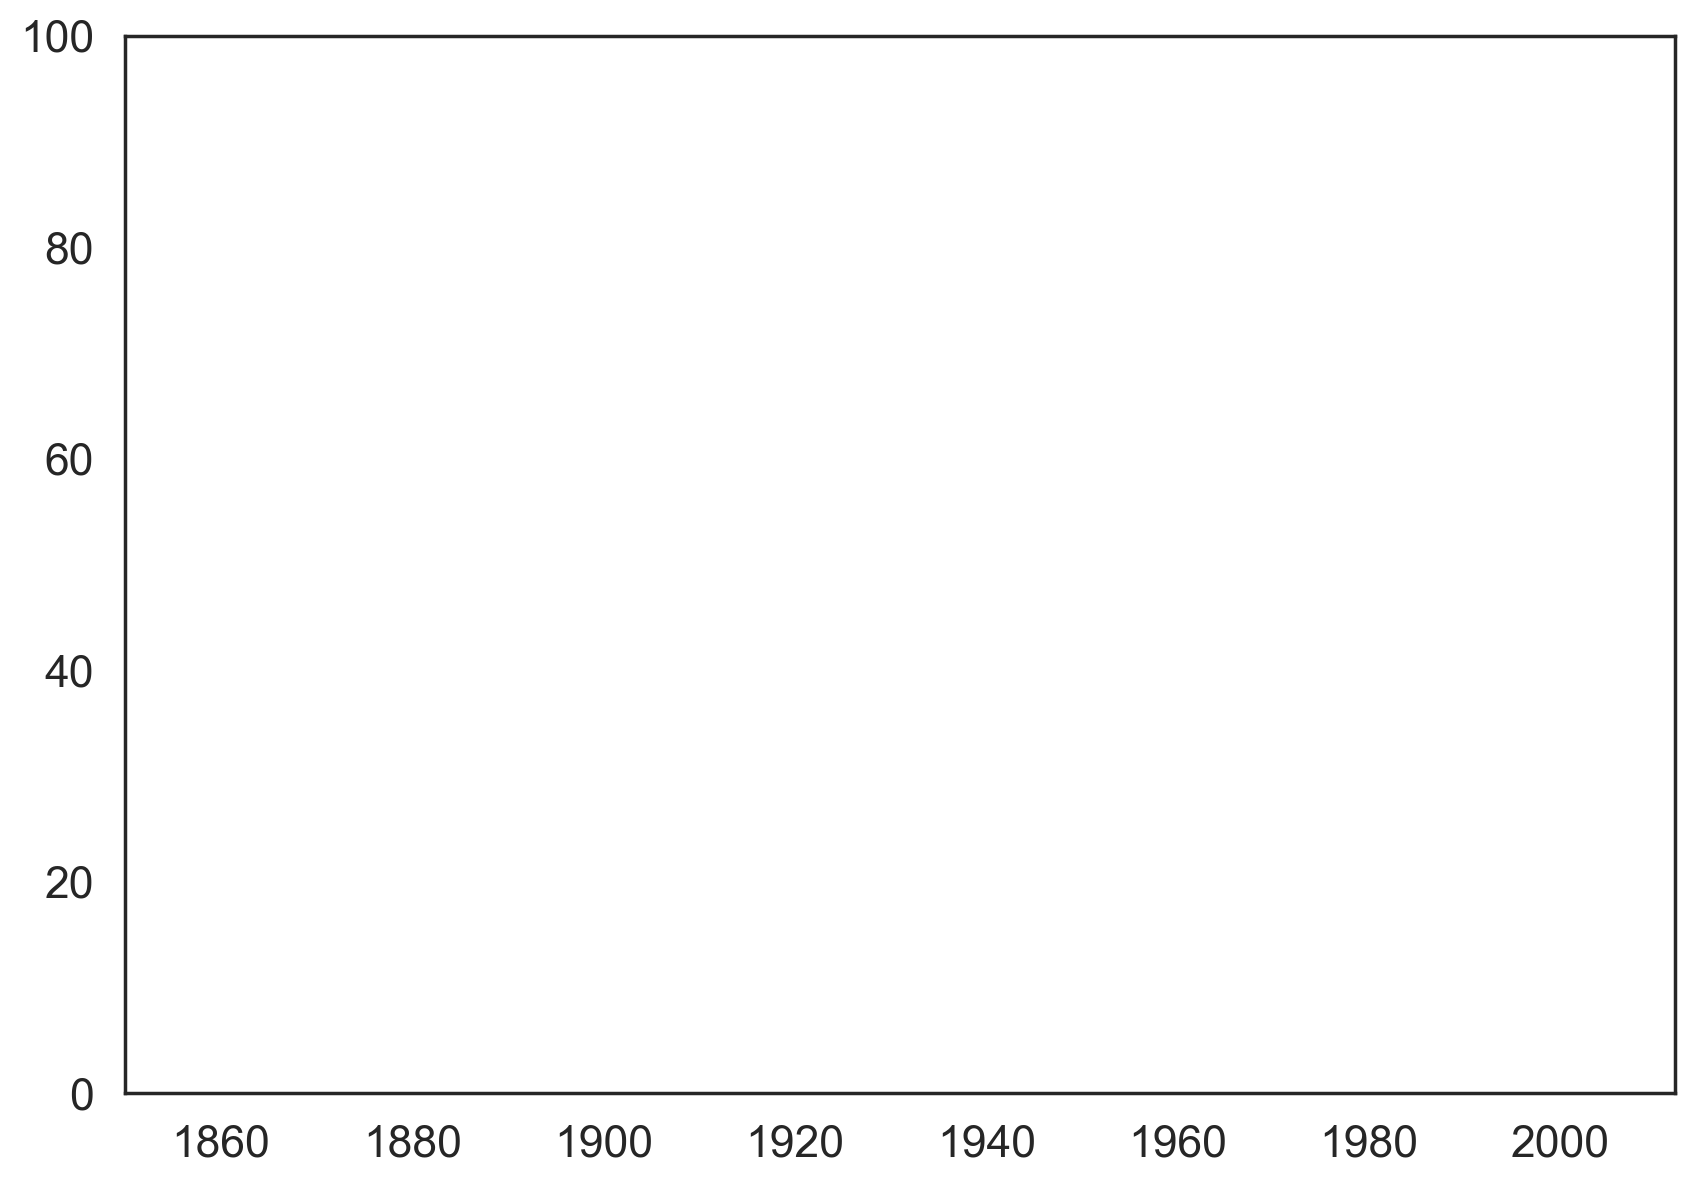

In [5]:
plt.figure(figsize=(10, 7), dpi=200)
plt.ylim(0, 100)
plt.xlim(1850, 2012)

#Get year/opinion count figures for top 10 judges
for justice in most_prolific.index.tolist()[:5]:
    x,y = zip(*authors[justice].items())
    plt.scatter(x,y, alpha=0.5, label=justice)


plt.title("5 Most Prolific Judges")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(fontsize=10)
plt.savefig("prolificness2.png")
plt.show()

Interesting – all of these judges worked in the first half of the 20th century or earlier. It looks like most of these prolific opinion writers are Supreme Court justices. Let's look at Mr. Justice Cartwright, our most prolific judge. Cartwright served on the Illinois Supreme Court from 1895 to 1924.

In [47]:
#Filter the dataframe down to entries mentioning Cartwright
cartwright = df_opinions[(df_opinions["author"].str.contains('Cartwright')) & \
                         (df_opinions["date"] >= '01-01-1895') &              \
                         (df_opinions["date"] < '05-18-1924')]
#Sort by date
cartwright = cartwright.sort_values('date').reset_index(drop=True)
#Let's see how Cartwright is listed as an author
cartwright["author"].value_counts()[:15]

Mr. Justice Cartwright              1586
Mr. Chief Justice Cartwright         296
Mr. Presiding Justice Cartwright      28
Mr. Justice Cartwright,               22
Mr. Chiee Justice Cartwright          15
Mr. Justice; Cartwright                9
Mr. Chief Justice Cartwright,          7
Dunn and Cartwright, JJ.,              7
Mr. Justicr Cartwright                 6
Cartwright and Hand, JJ.,              6
Mr. Chibe Justice Cartwright           6
Mr. ChiEE Justice Cartwright           5
Hand and Cartwright, JJ.,              5
Mr. Chile Justice Cartwright           4
Cartwright, Hand and Dunn, JJ.,        3
Name: author, dtype: int64

As always with OCR data, there are some issues here. It would take a lot of manual cleaning to get it perfect, so let's just fix some of the more common OCR errors

In [48]:
#Clean cartwright's entries up a little bit
aliases_justice = ["Cartwright, J.", "Mr. Justice Cartwright,", "Mr. Justice; Cartwright", 
                   "Mr. Justicr Cartwright", "Mr. JusTicp Cartwright"]
cartwright = cartwright.replace(aliases_justice, "Mr. Justice Cartwright")

aliases_chief_justice = ["Mr. Chiee Justice Cartwright", "Mr. Chief Justice Cartwright,",
                        "Mr. Chibe Justice Cartwright", "Mr. ChiEE Justice Cartwright",
                        "Mr. Chile Justice Cartwright"]
cartwright = cartwright.replace(aliases_chief_justice, "Mr. Justice Cartwright")

Let's find out a little bit more about Cartwright – how many dissents and majority opinions did he write, and what cases did he dissent on? What were the titles of the cases he entered opinions on in 1924-04-14 (his last opinions before his death)?

In [49]:
cartwright['type'].value_counts()

majority       2013
dissent         123
concurrence      14
rehearing         1
Name: type, dtype: int64

In [50]:
cartwright[cartwright['type'] == 'dissent'].head(5)

,author,citation,court,date,jurisdiction,name,text,type
267,"Craig, Wilkin and Cartwright, JJ.,",175 Ill. 125,Illinois Supreme Court,1898-10-24,Illinois,"The People ex rel. Moloney, Attorney General, ...",dissenting: We do not concur in the foregoing ...,dissent
269,Mr. Justice Cartwright,176 Ill. 471,Illinois Supreme Court,1898-10-24,Illinois,The Baltimore and Ohio Southwestern Railway Co...,dissenting: I cannot agree to the rule stated ...,dissent
293,"Phillips and Cartwright, JJ.,",177 Ill. 525,Illinois Supreme Court,1898-12-21,Illinois,"St. Louis, Alton and Springfield Railroad Co. ...",dissenting: We do not concur in giving to the ...,dissent
315,"Cartwright and Craig, JJ.:",179 Ill. 62,Illinois Supreme Court,1899-04-17,Illinois,Franklin P. Simons et al. v. Alice Drake,We dissent from so much of the foregoing opini...,dissent
334,Mr. Justice Cartwright,181 Ill. 289,Illinois Supreme Court,1899-10-16,Illinois,The Pennsylvania Company et al. v. The City of...,dissenting: The occupation of a street as a pl...,dissent


In [78]:
cartwright[cartwright['date'] == '1924-04-14']['name'].tolist()

['The International Lumber Company, Appellant, vs. Louis L. Emmerson, Secretary of State, Appellee',
 'The Congress Hotel Company, Appellant, vs. Laura Martin. — (The First Trust and Savings Bank, Trustee, Appellee.)',
 'James B. Depler el al. Appellants, vs. James H. Dyer et al. Appellees',
 'Joseph Reder, Plaintiff in Error, vs. Emma Reder, Admx., Defendant in Error',
 'The Wasson Coal Company, Plaintiff in Error, vs. The Industrial Commission et al. — (Lucy Clayton, Defendant in Error.)',
 'Lena Speirer, Appellee, vs. Arthur J. Curtis et al. Appellants',
 'The People of the State of Illinois, Defendant in Error, vs. Sanford Rosenbaum, Plaintiff in Error',
 'Leona V. Fortner, Defendant in Error, vs. The Industrial Commission et al. — (James W. Fortner et al. Plaintiffs in Error.)',
 'Charles Cossitt Shedd et al. Exrs., Appellants, vs. Alvina F. Patterson, Admx., Appellee',
 'The People ex rel. James Lord, County Collector, Appellee, vs. The Wabash Railway Company et al. Appellants',


This is interesting, and there's much more we could learn about Cartwright from the case data. However, let's broaden our analysis a little bit to contextualize Cartwright's work within that of the Illinois Supreme Court during his tenure.

In [17]:
#Filter opinions dataframe to include only opinions of the Illinois Supreme Court 1895-1925
peers_df = df_opinions[(df_opinions["date"] >= '01-01-1895') & \
                       (df_opinions["date"] < '1-1-1925') & \
                       (df_opinions["court"] == "Illinois Supreme Court")]
peers_df.head()

,author,citation,court,date,jurisdiction,name,opinion_count,text,type
34753,Mr. Chief Justice Thompson,307 Ill. 539,Illinois Supreme Court,1923-04-18,Illinois,"The People of the State of Illinois, Defendant...",1,delivered the opinion of the court: The grand ...,majority
34754,Mr. Justice Duncan,307 Ill. 482,Illinois Supreme Court,1923-04-18,Illinois,"The People ex rel. Samuel J. Stout, Appellant,...",2,delivered.the opinion of the court: The State’...,majority
34755,Mr. Chief Justice Thompson,307 Ill. 482,Illinois Supreme Court,1923-04-18,Illinois,"The People ex rel. Samuel J. Stout, Appellant,...",2,specially concurring: I concur in the conclusi...,concurrence
34756,Mr. Justice Duncan,307 Ill. 492,Illinois Supreme Court,1923-04-18,Illinois,"The People of the State of Illinois, Defendant...",1,delivered the opinion of the court: Adam Berkm...,majority
34757,Mr. Justice Dunn,307 Ill. 544,Illinois Supreme Court,1923-04-18,Illinois,"The People of the State of Illinois, Defendant...",1,delivered the opinion of the court: The Dupo S...,majority


Let's look at some of the most prolific judges over this 30 year period in the court's history (and clean up our opinions' "author" fields, if possible)

In [14]:
peers_df["author"].value_counts()[:50]

Mr. Justice Cartwright          1579
Mr. Justice Carter              1383
Mr. Justice Dunn                1293
Mr. Justice Craig               1214
Mr. Justice Farmer              1105
Mr. Justice Wilkin               986
Mr. Justice Stone                980
Mr. Justice Magruder             852
Mr. Justice Scott                845
Mr. Justice Hand                 648
Mr. Justice Duncan               601
Mr. Justice Scholfield           578
Per Curiam :                     569
Mr. Justice Sheldon              555
Mr. Justice Boggs                554
Mr. Justice Thompson             545
Per Curiam:                      524
Mr. Justice Walker               460
Mr. Justice Vickers              440
Mr. Justice Cooke                422
Mr. Justice Heard                406
Mr. Justice Baker                403
Mr. Justice DeYoung              381
Mr. Justice Phillips             357
Mr. Justice Dickey               341
Mr. Justice Mulkey               330
Mr. Justice Orr                  311
M

While a lot of these look pretty good, there are a few major problems that we should solve before we start comparing justices.

- Chief Justice and Associate Justice opinions are listed separately for each justice (the Chief Justice of the Illinois Supreme Court is reelected every three years from among the justices), and should be consolidated.
- There are some clear OCR errors and inconsistencies that should be standardized (trailing commas and "Chiee" Justices, for instance). NOTE: ~2% of entries in this dataframe still contain less common OCR errors.
- Per Curiam opinions are showing up in a range of OCR formats.

In [15]:
#Implement an (incomplete) range of 
def clean_authors(author):
    a = author
    aliases_justice = ["Mr. Chiee Justice", "Mr. Chief Justice",
                        "Mr. Chibe Justice", "Mr. ChiEE Justice",
                        "Mr. Chile Justice", "Mr. Chiep Justice",
                        "Mr. Ciiiep Justice"]
    for alias in aliases_justice:
        a = a.replace(alias, "Mr. Justice")
        
    a = a.replace("Chief ", "").replace(",", "").replace("'", "").replace(":", "").replace(";", "")
    a = a.replace("-", "").replace("Chiee ", "").replace("delivered", "").strip()    
    a = a.replace("Parmer", "Farmer").replace("Earmer", "Farmer").replace("Vicicers", "Vickers")
    a = a.replace("Garter", "Carter").replace("Ricics", "Ricks").replace("Eicks", "Ricks")
    a = a.replace("Cooice", "Cooke").replace("Cartwrigi-it", "Cartwright").replace("CooicE", "Cooke")
    a = a.replace("Mr ", "Mr.").replace("Mr.J", "Mr. J").replace("Wilicin", "Wilkin").replace("Wieicin", "Wilkin")
    a = a.replace("Macruder", "Magruder").replace("Cartwrigiit", "Cartwright")
    a = a.replace("Phillips J.", "Mr. Justice Phillips")
    a = a.replace("Craig J.", "Mr. Justice Craig")
    a = a.replace("Baker J.", "Mr. Justice Baker")
    a = a.replace("Magruder J.", "Mr. Justice Magruder").replace("MagrudER", "Magruder").replace("MagrudEr", "Magruder")
    a = a.replace("Justicr", "Justice").replace("J ustice", "Justice"). replace("JUSTICE", "Justice")
    a = a.strip()
    return a
    
peers_df["author"] = peers_df["author"].apply(clean_authors)
peers_df = peers_df.drop(peers_df[peers_df["author"] == "Mr. Justice"].index)
peers_df = peers_df.drop(peers_df[peers_df["author"] == "Per Curiam"].index)
peers_df = peers_df.drop(peers_df[peers_df["author"] == ""].index)
peers_df.loc[(peers_df["date"] > '1913-01-01') & (peers_df["author"] == "Mr. Justice Craig"), "author"] = "Mr. Justice Charles Craig"
peers_df.loc[(peers_df["date"] < '1913-01-01') & (peers_df["author"] == "Mr. Justice Craig"), "author"] = "Mr. Justice Alfred Craig"
peers_df.loc[(peers_df["date"] > '1903-01-01') & (peers_df["author"] == "Mr. Justice Carter"), "author"] = "Mr. Justice Orrin Carter"
peers_df.loc[(peers_df["date"] < '1903-01-01') & (peers_df["author"] == "Mr. Justice Carter"), "author"] = "Mr. Justice Joseph Carter"


#The top 22 entries are real justices – value chosen by examination
justices = peers_df["author"].value_counts()[:22].keys().tolist()
peers_df["author"].value_counts()[:22]

/Users/JohnBowers/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Mr. Justice Cartwright       1980
Mr. Justice Dunn             1545
Mr. Justice Farmer           1376
Mr. Justice Alfred Craig     1240
Mr. Justice Stone            1234
Mr. Justice Wilkin           1137
Mr. Justice Scott            1132
Mr. Justice Orrin Carter     1131
Mr. Justice Magruder         1109
Mr. Justice Hand              817
Mr. Justice Duncan            726
Mr. Justice Scholfield        709
Mr. Justice Sheldon           702
Mr. Justice Thompson          653
Mr. Justice Boggs             623
Mr. Justice Walker            576
Mr. Justice Vickers           523
Mr. Justice Cooke             521
Mr. Justice Joseph Carter     520
Mr. Justice Heard             502
Mr. Justice Phillips          453
Mr. Justice DeYoung           445
Name: author, dtype: int64

That looks a good bit better. Notice that OCR errors and standardization can have a huge impact on the accuracy of statistics extracted from CAP datasets – be sure to clean carefully. 

Let's ignore the jointly written opinions for now and start comparing our justices. To start, let's take a look at the number of opinions written by each justice on a year by year basis: 

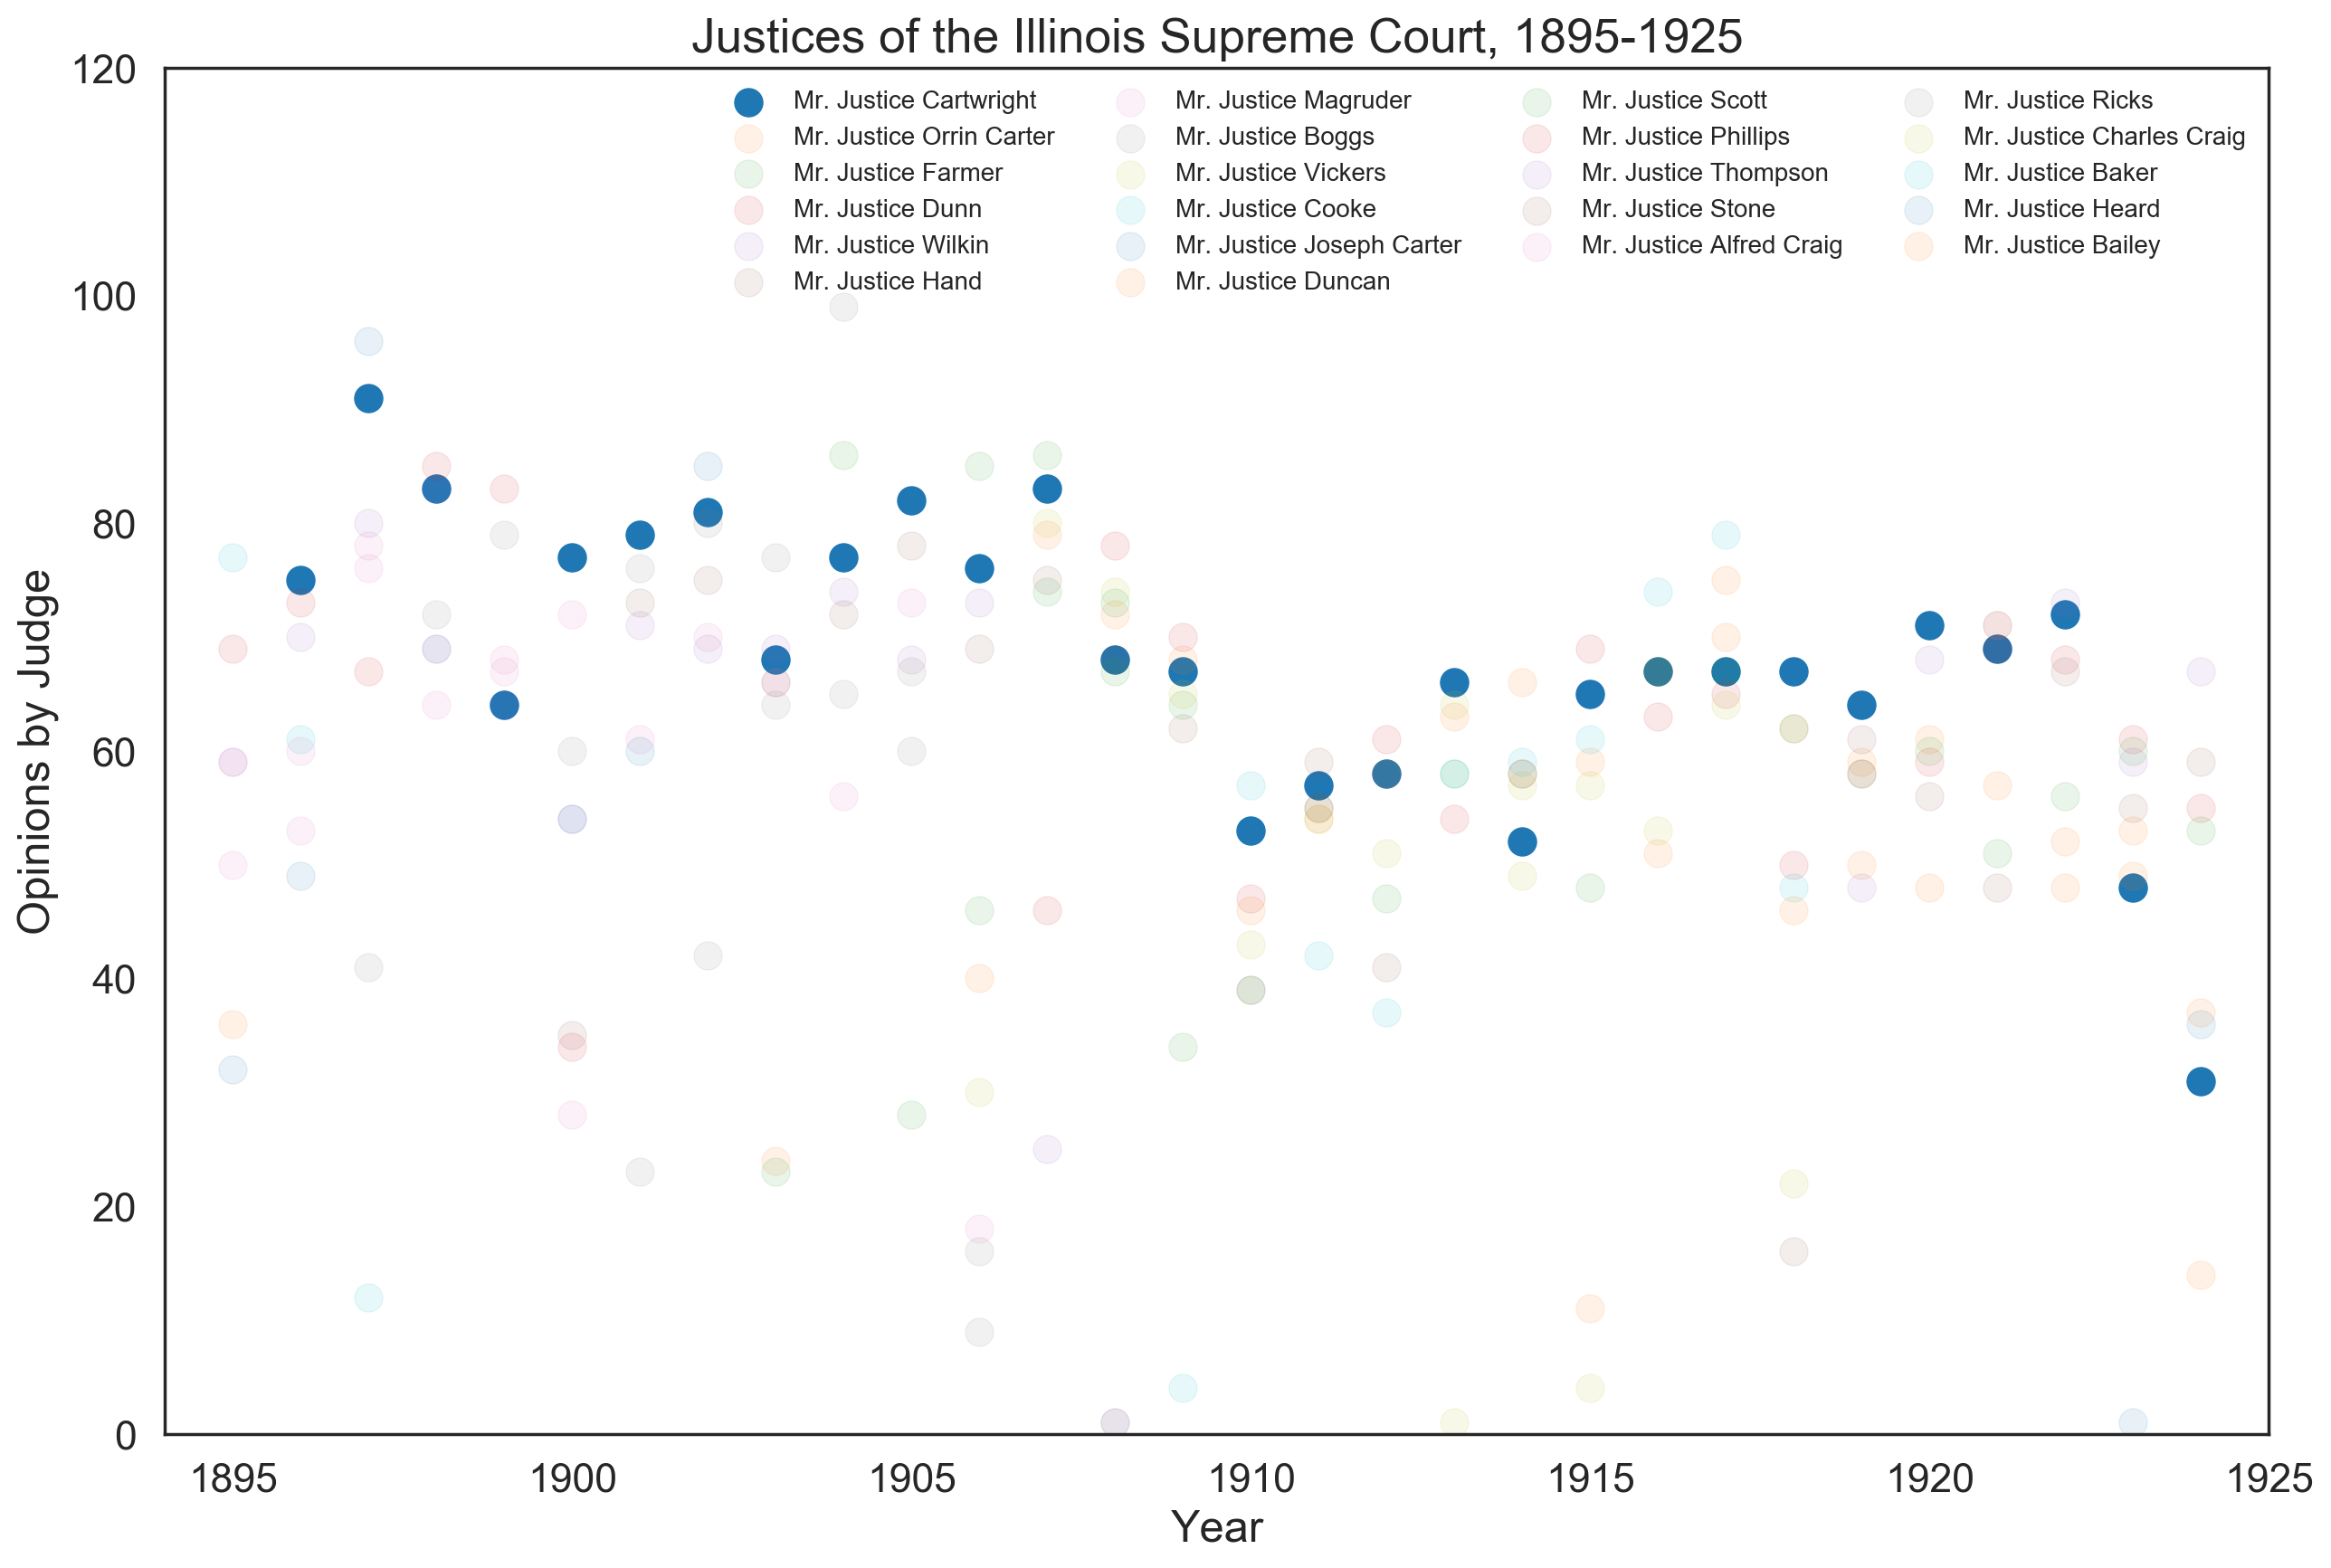

In [72]:
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 120)
plt.xlim(1894, 1925)

#Get year/opinion count figures for each justice in the set
for justice in justices:
    items = peers_df[peers_df["author"] == justice]["date"].apply(lambda x:x.year).value_counts().items()
    x,y = zip(*items)
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.1
    plt.scatter(x,y, alpha=alp, label=justice)


plt.title("Justices of the Illinois Supreme Court, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge")
plt.legend(ncol=4, fontsize=10)
plt.savefig("cartwright1.png")
plt.show()

Cartwright consistently has the highest or near-highest output of opinions throughout his 30-year career (with the exception of the 2 years leading up to his death). Impressive! Let's learn more about his case writing patterns...

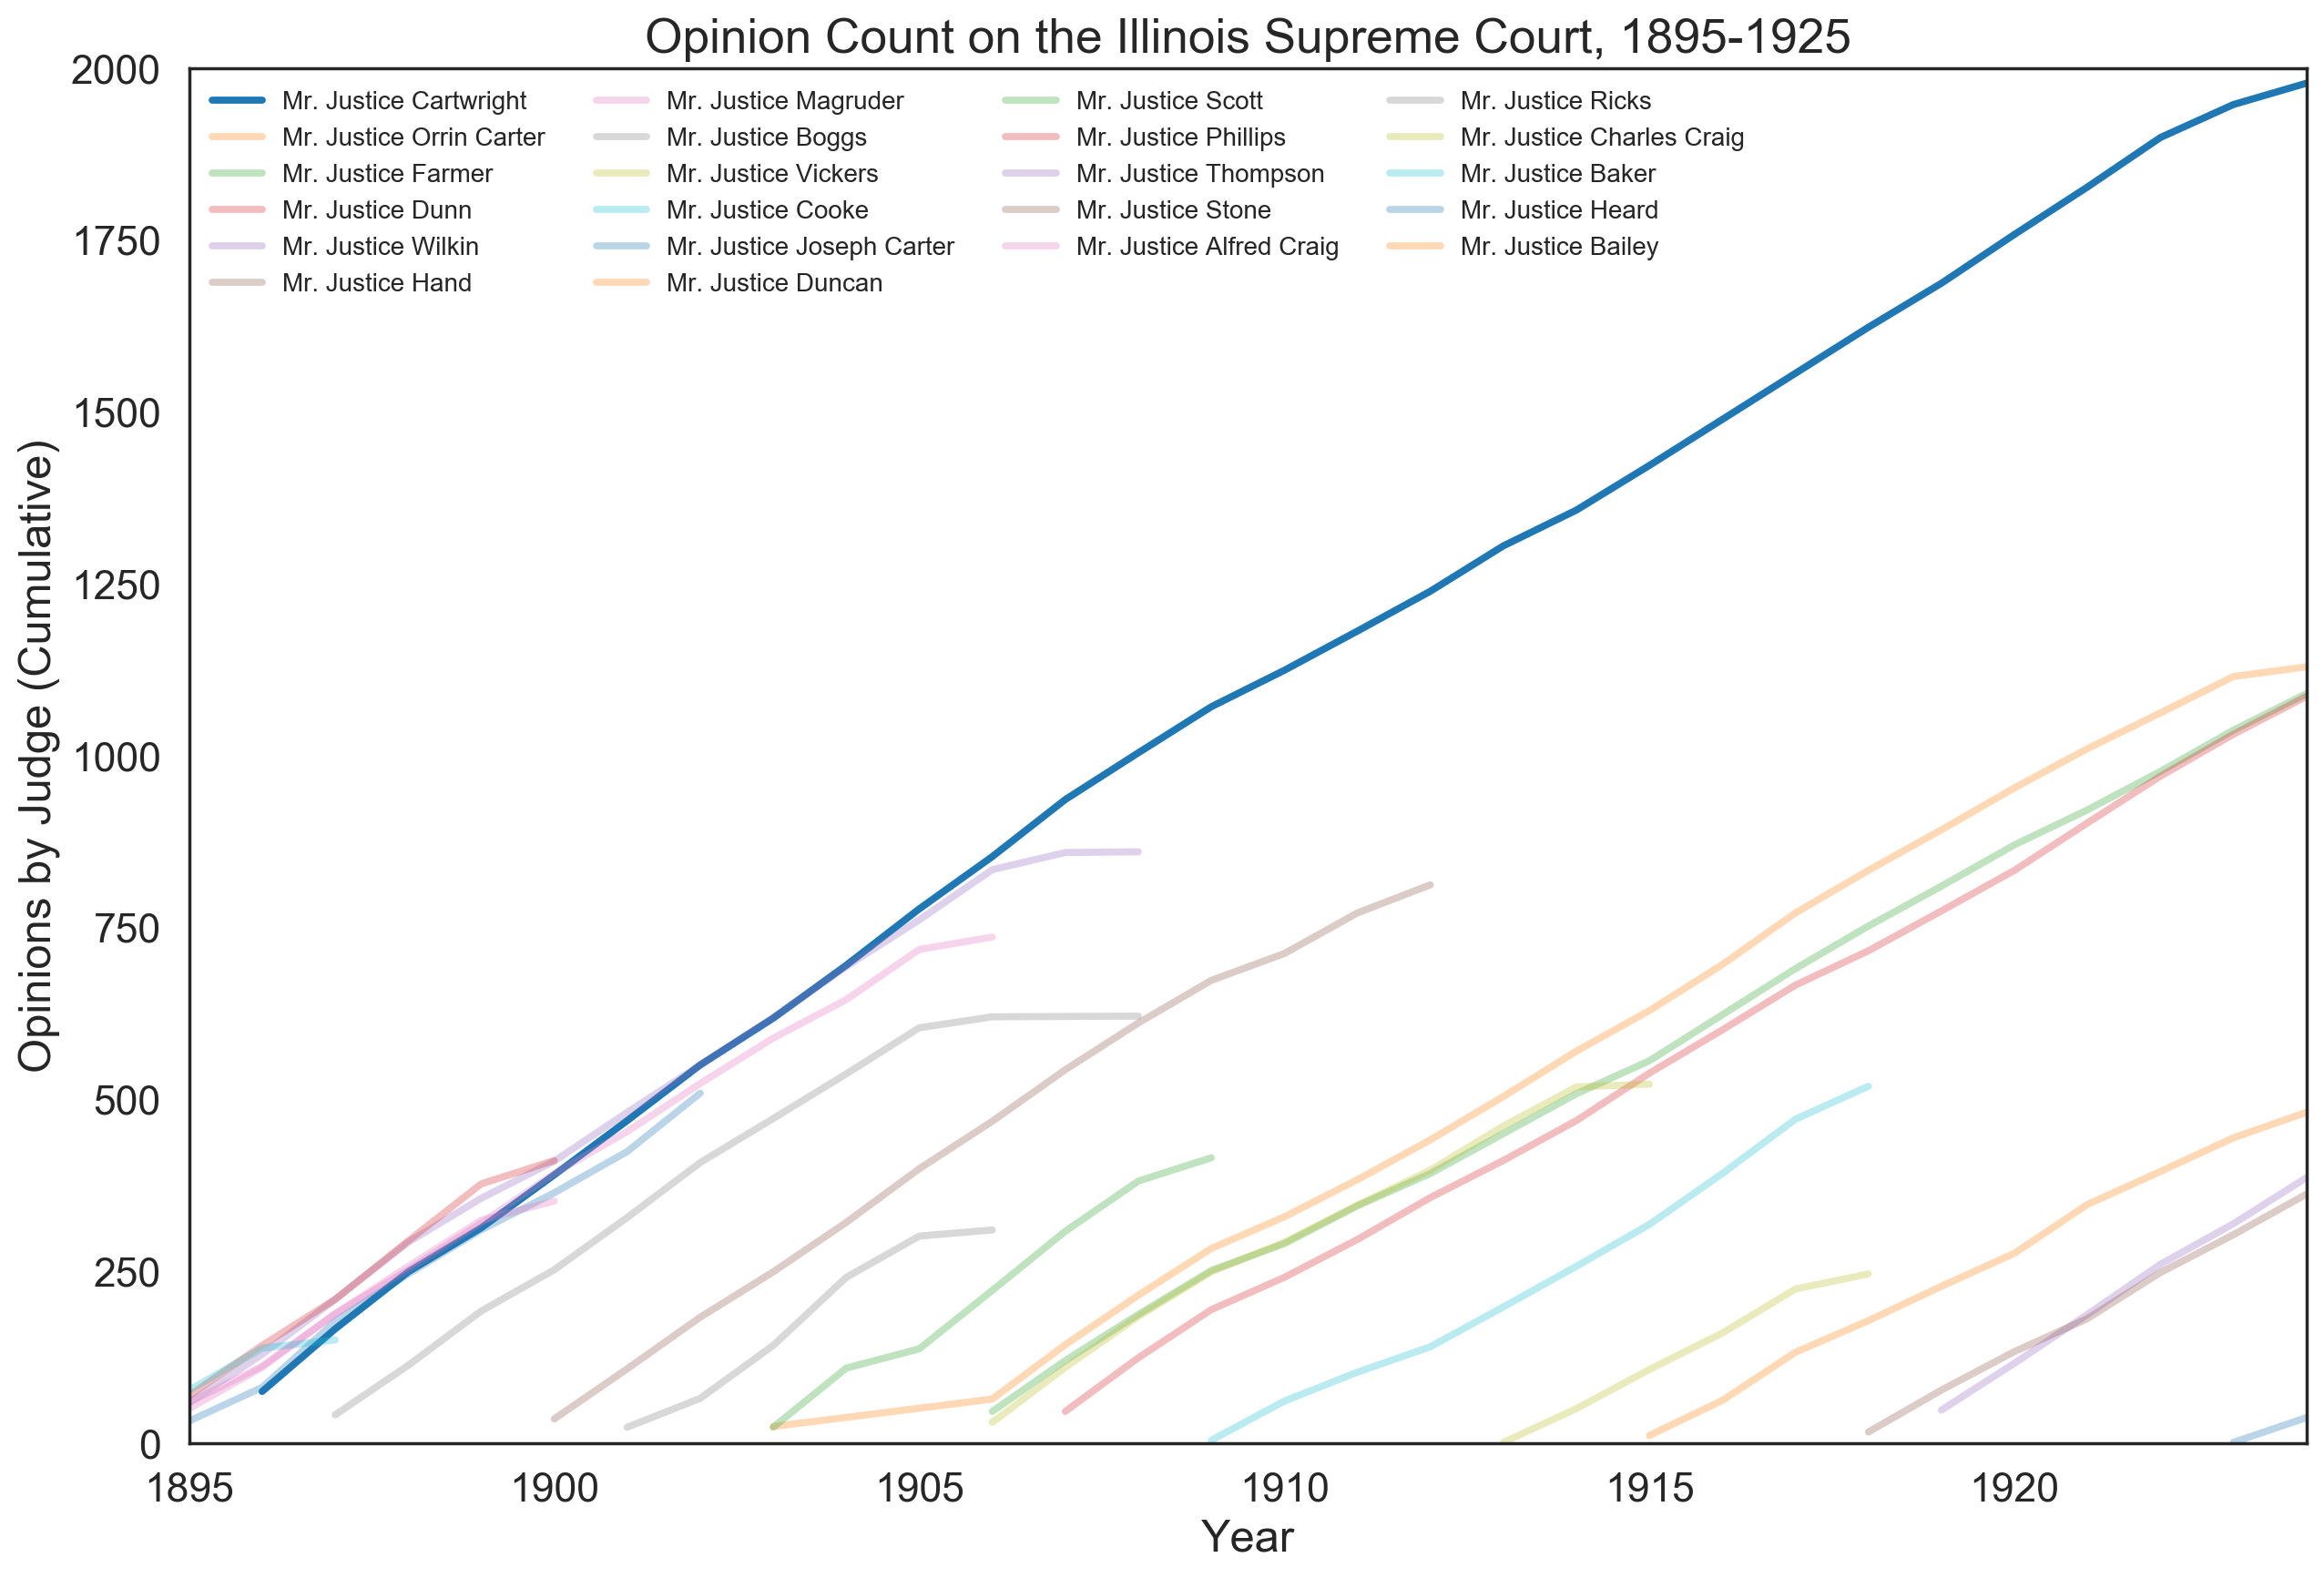

In [73]:
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 2000)
plt.xlim(1895, 1924)

#Calculate cumulative opinion count over timespan. 
#Note that this does not account for opinions written prior to 1895
for justice in justices:
    items = peers_df[peers_df["author"] == justice]["date"].apply(lambda x:x.year).value_counts().items()
    items = sorted(items, key=lambda x:x[0])
    x,y = zip(*items)
    x,y = list(x), list(y)
    for i in range(1, len(y)):
        y[i] = y[i] + y[i-1]
        i += 1
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.3
    plt.plot(x,y, alpha=alp, label=justice)


plt.title("Opinion Count on the Illinois Supreme Court, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Opinions by Judge (Cumulative)")
plt.legend(ncol=4, fontsize=10)
plt.savefig("cartwright2.png")
plt.show()

Cartwright wrote cases at a formidible rate for a very long time. While his production was matched or outstripped by multiple other justices at different points throughout his career (particularly Justice Carter), nobody could touch his consistency throughout this 30-year period.

But how long were all these opinions? Let's generate some opinion length statistics for our justices.

In [77]:
prep_df_words = []
for justice in justices:
    just_df = peers_df[peers_df["author"] == justice]
    temp = {}
    temp["justice"] = justice
    temp["total_words"] = sum(just_df["text"].apply(lambda x: len(x.split(" "))))
    temp["opinions"] = len(just_df)
    temp["avg_words"] = temp["total_words"]/temp["opinions"]
    prep_df_words.append(temp)

display_word_results = pd.DataFrame(prep_df_words, columns=["justice", "opinions", "total_words", "avg_words"])

print("{:,} words across all justices".format(sum(display_word_results["total_words"])))
average_length = sum(display_word_results["total_words"])/sum(display_word_results["opinions"])
print("Average opinion length of {:,} words across all justices".format(round(average_length)))


display_word_results.sort_values('total_words', ascending=False).reset_index(drop=True)

25,426,543 words across all justices
Average opinion length of 1,949 words across all justices


,justice,opinions,total_words,avg_words
0,Mr. Justice Cartwright,1978,3411869,1724.908493
1,Mr. Justice Orrin Carter,1129,2493649,2208.723649
2,Mr. Justice Farmer,1090,2201985,2020.169725
3,Mr. Justice Magruder,736,2039174,2770.616848
4,Mr. Justice Dunn,1086,1960427,1805.181400
5,Mr. Justice Hand,812,1473052,1814.103448
6,Mr. Justice Wilkin,860,1266930,1473.174419
7,Mr. Justice Duncan,481,1240269,2578.521830
8,Mr. Justice Boggs,621,1220810,1965.877617
9,Mr. Justice Vickers,522,1129585,2163.955939


/Users/JohnBowers/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


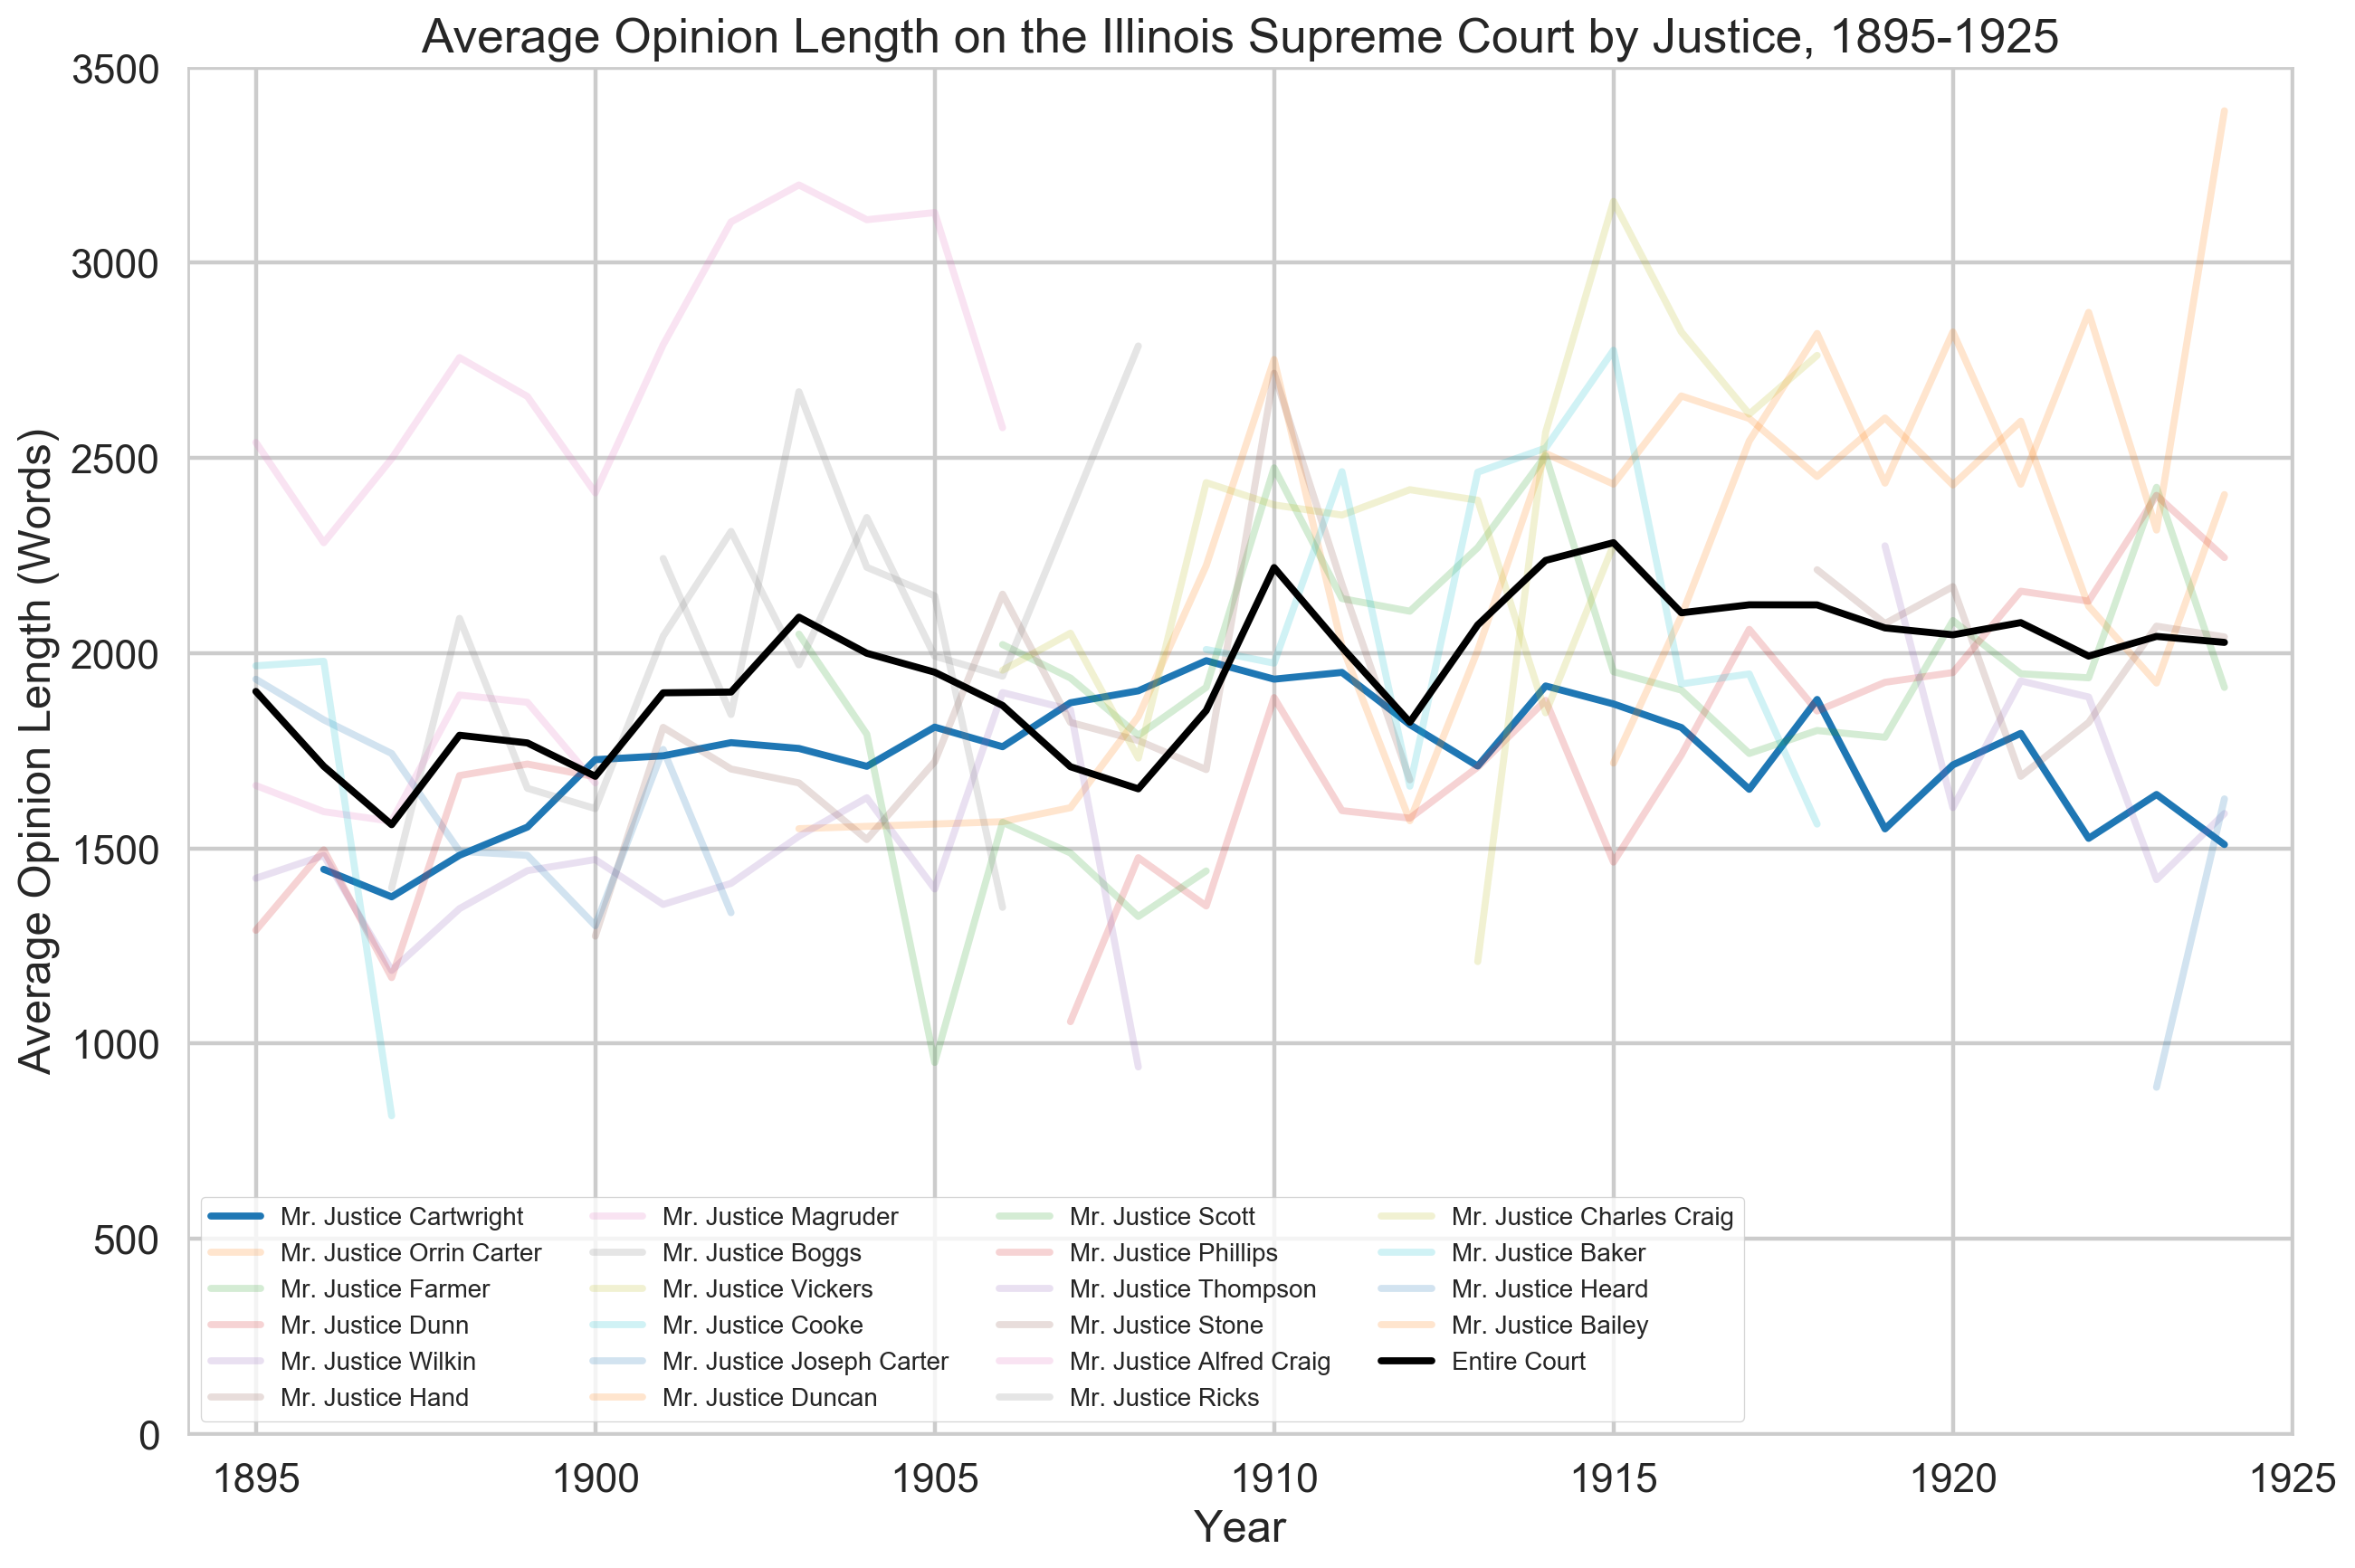

In [76]:
se.set_style('whitegrid')
plt.figure(figsize=(15, 10), dpi=200)
plt.ylim(0, 3500)
plt.xlim(1894, 1925)

#plot average word count per year for each justice on the court
for justice in justices:
    temp_df = peers_df[peers_df["author"] == justice]
    temp_df["year"] = temp_df["date"].apply(lambda x:x.year)
    items = []
    for year in sorted(temp_df["year"].unique()):
        total_words = sum(temp_df[temp_df["year"] == year]["text"].apply(lambda x: len(x.split(" "))))
        avg_words = total_words/len(temp_df[temp_df["year"] == year])
        items.append((year, avg_words))
    x,y = zip(*items)
    alp = 1.0 if justice == "Mr. Justice Cartwright" else 0.2
    plt.plot(x,y, alpha=alp, label=justice)

#run one more plot for the whole court
temp_df = peers_df
temp_df["year"] = temp_df["date"].apply(lambda x:x.year)
items = []
for year in sorted(temp_df["year"].unique()):
    total_words = sum(temp_df[temp_df["year"] == year]["text"].apply(lambda x: len(x.split(" "))))
    avg_words = total_words/len(temp_df[temp_df["year"] == year])
    items.append((year, avg_words))
x,y = zip(*items)
plt.plot(x,y, alpha=1.0, color='black', label="Entire Court")

plt.title("Average Opinion Length on the Illinois Supreme Court by Justice, 1895-1925")
plt.xlabel("Year")
plt.ylabel("Average Opinion Length (Words)")
plt.legend(ncol=4, fontsize=10, frameon=True)
plt.savefig("cartwright3.png")
plt.show()

Cartwright wrote more words than any other justice across this period in the court's history, but his opinions did tend to be on the shorter side. There's an exception to every rule, of course...

In [32]:
peers_df["op_length"] = peers_df["text"].apply(lambda x: len(x.split(" ")))
peers_df[peers_df["author"] == "Mr. Justice Cartwright"].sort_values("op_length")[-1:]

,author,citation,court,date,jurisdiction,name,text,type,year,op_length
51208,Mr. Justice Cartwright,186 Ill. 510,Illinois Supreme Court,1900-10-19,Illinois,H. W. Lightcap v. Lydia Bradley,delivered the opinion of the court: Five eject...,majority,1900,8025


... for Cartwright, that would be his 8,025 word majority opionion in the 1900 case 'H. W. Lightcap v. Lydia Bradley.'

In [33]:
peers_df.sort_values("op_length")[-1:]

,author,citation,court,date,jurisdiction,name,text,type,year,op_length
50027,Mr. Justice Duncan,312 Ill. 396,Illinois Supreme Court,1924-04-14,Illinois,"The Chicago Title and Trust Company, Receiver,...",delivered the opinion of the court: Some of th...,majority,1924,42735


That case, however, pales in comparison to the court's longest opinion in this period of its history, Justice Duncan's gargantuan 42,735 word majority opinion in 1924's 'The Chicago Title and Trust Company, Receiver, Appellant, vs. The Central Trust Company of Illinois, Appellee; The Chicago Title and Trust Company, Appellee, vs. The Central Trust Company of Illinois, Appellant'